### 1. Khai báo các thư viện cần thiết

In [1]:
import sys
import os

project_path = 'c:\\Users\\84936\\Desktop\\Do_an_TV'

if os.getcwd() != project_path:
    os.chdir(project_path)

if project_path not in sys.path:
    sys.path.append(project_path)


In [2]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from TextEncoder import TextEncoder
from TextPreprocessor import TextPreprocessor
from sklearn.preprocessing import LabelEncoder
from TF_IDF import TF_IDF

from tensorflow import keras
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 2. Đọc vào dữ liệu và đưa ra các thống kê cơ bản

In [3]:
data = pd.read_excel(r'dataset/benh_an.xlsx')
data = data.dropna()

In [4]:
# Đưa ra 10 mẫu bất kỳ
data.sample(10)

,label,text
1451,Bệnh sốt xuất huyết,Tôi bị sốt cao kèm theo nhức đầu dữ dội và đau...
471,Bệnh trĩ lưỡng hình,Táo bón khiến tôi gặp khó khăn khi đi vệ sinh....
379,Bệnh cảm lạnh thông thường,Tôi bị ho và cảm lạnh khó chịu trong nhiều ngà...
3579,Bệnh tắc nghẽn mãn tính,Tôi bị ho dai dẳng vì sụt cân ngoài ý muốn. Nh...
409,Bệnh viêm phổi,Tôi khó thở và sốt rất cao. Tôi đổ mồ hôi rất ...
2814,Bệnh sốt xuất huyết,Những xét nghiệm nào thường được khuyên dùng c...
66,Bệnh giãn tĩnh mạch,Vết ban ở chân của tôi ngày càng lan rộng và t...
4389,Bệnh phản ứng thuốc,"ngứa, đau bụng, tiểu buốt, tiểu ra máu"
725,Bệnh đau nửa đầu,"Tôi đang gặp các vấn đề về tiêu hóa, bao gồm a..."
266,Bệnh sốt xuất huyết,Tôi cảm thấy mệt mỏi tột độ và khiến tôi khó ...


In [5]:
print(f"Có {data['label'].nunique()} nhãn, lần lượt là: {data['label'].unique()}")

Có 60 nhãn, lần lượt là: ['Bệnh vẩy nến' 'Bệnh giãn tĩnh mạch' 'Bệnh thương hàn' 'Bệnh thủy đậu'
 'Bệnh chốc lở' 'Bệnh sốt xuất huyết' 'Bệnh nhiễm nấm'
 'Bệnh cảm lạnh thông thường' 'Bệnh viêm phổi' 'Bệnh trĩ lưỡng hình'
 'Bệnh viêm khớp' 'Bệnh mụn trứng cá' 'Bệnh hen phế quản'
 'Bệnh tăng huyết áp' 'Bệnh đau nửa đầu' 'Bệnh thoái hóa đốt sống cổ'
 'Bệnh vàng da' 'Bệnh sốt rét' 'Bệnh nhiễm trùng đường tiết niệu'
 'Bệnh dị ứng' 'Bệnh trào ngược dạ dày thực quản' 'Bệnh phản ứng thuốc'
 'Bệnh loét dạ dày' 'Bệnh tiểu đường' 'Bệnh cúm' 'Bệnh lao'
 'Bệnh hiv/aids' 'Bệnh covid-19' 'Bệnh viêm gan' 'Bệnh tả'
 'Bệnh do virus ebola' 'Bệnh động mạch vành (cad)'
 'Bệnh đau tim (nhồi máu cơ tim)' 'Bệnh đột quỵ'
 'Bệnh loạn nhịp tim (nhịp tim không đều)' 'Bệnh xơ vữa động mạch'
 'Bệnh ung thư vú' 'Bệnh ung thư phổi' 'Bệnh ung thư tuyến tiền liệt'
 'Bệnh ung thư đại trực tràng' 'Bệnh ung thư da (khối u ác tính)'
 'Bệnh ung thư não' 'Bệnh bạch cầu' 'Bệnh tắc nghẽn mãn tính'
 'Bệnh phổi (copd)' 'Bệnh phổ

In [6]:
data.shape

(8853, 2)

### 3. Tiền xử lý cột text

In [7]:
preprocessor = TextPreprocessor(r'dataset/vietnamese.txt')
data = preprocessor.preprocess_data(data)

In [8]:
data['text'].head()

0    phát_ban da tay_chân thân tuần màu đỏ ngứa bao...
1    da bong tróc đặc_biệt đầu_gối khuỷu da đầu bon...
2    đau khớp ngón cổ_tay đầu_gối đau nhức_nhối đau...
3    lớp bụi bạc bám da đặc_biệt lưng da đầu lớp bụ...
4    móng vết lõm vết rỗ cảm_giác viêm đau chạm thậ...
Name: text, dtype: object

### 4. Trực quan hóa dữ liệu

In [9]:
size = (500, 500)
mask = Image.new('RGB', size, (255, 255, 255))
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size[0], size[1]), fill=(0, 0, 0))
mask.save("circle_mask.png")

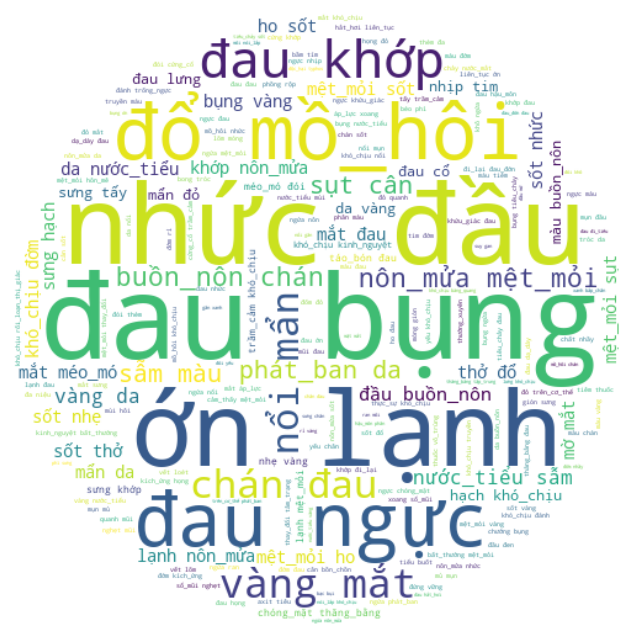

In [10]:
label_counts = data.groupby('label').size().reset_index(name='count')
sorted_labels = label_counts.sort_values(by='count', ascending=False)
sorted_data = data.merge(sorted_labels, on='label')
text = ' '.join(sorted_data['text'])
mask = np.array(Image.open("circle_mask.png"))
wc = WordCloud(background_color='white', contour_color='white', contour_width=1, mask=mask)
wordcloud = wc.generate(text)
wordcloud_image = wordcloud.to_image()
rotated_wordcloud_image = wordcloud_image.rotate(360, expand=True)
plt.figure(figsize=(8, 8))
plt.imshow(rotated_wordcloud_image, interpolation='bilinear')
plt.axis('off')
plt.show()

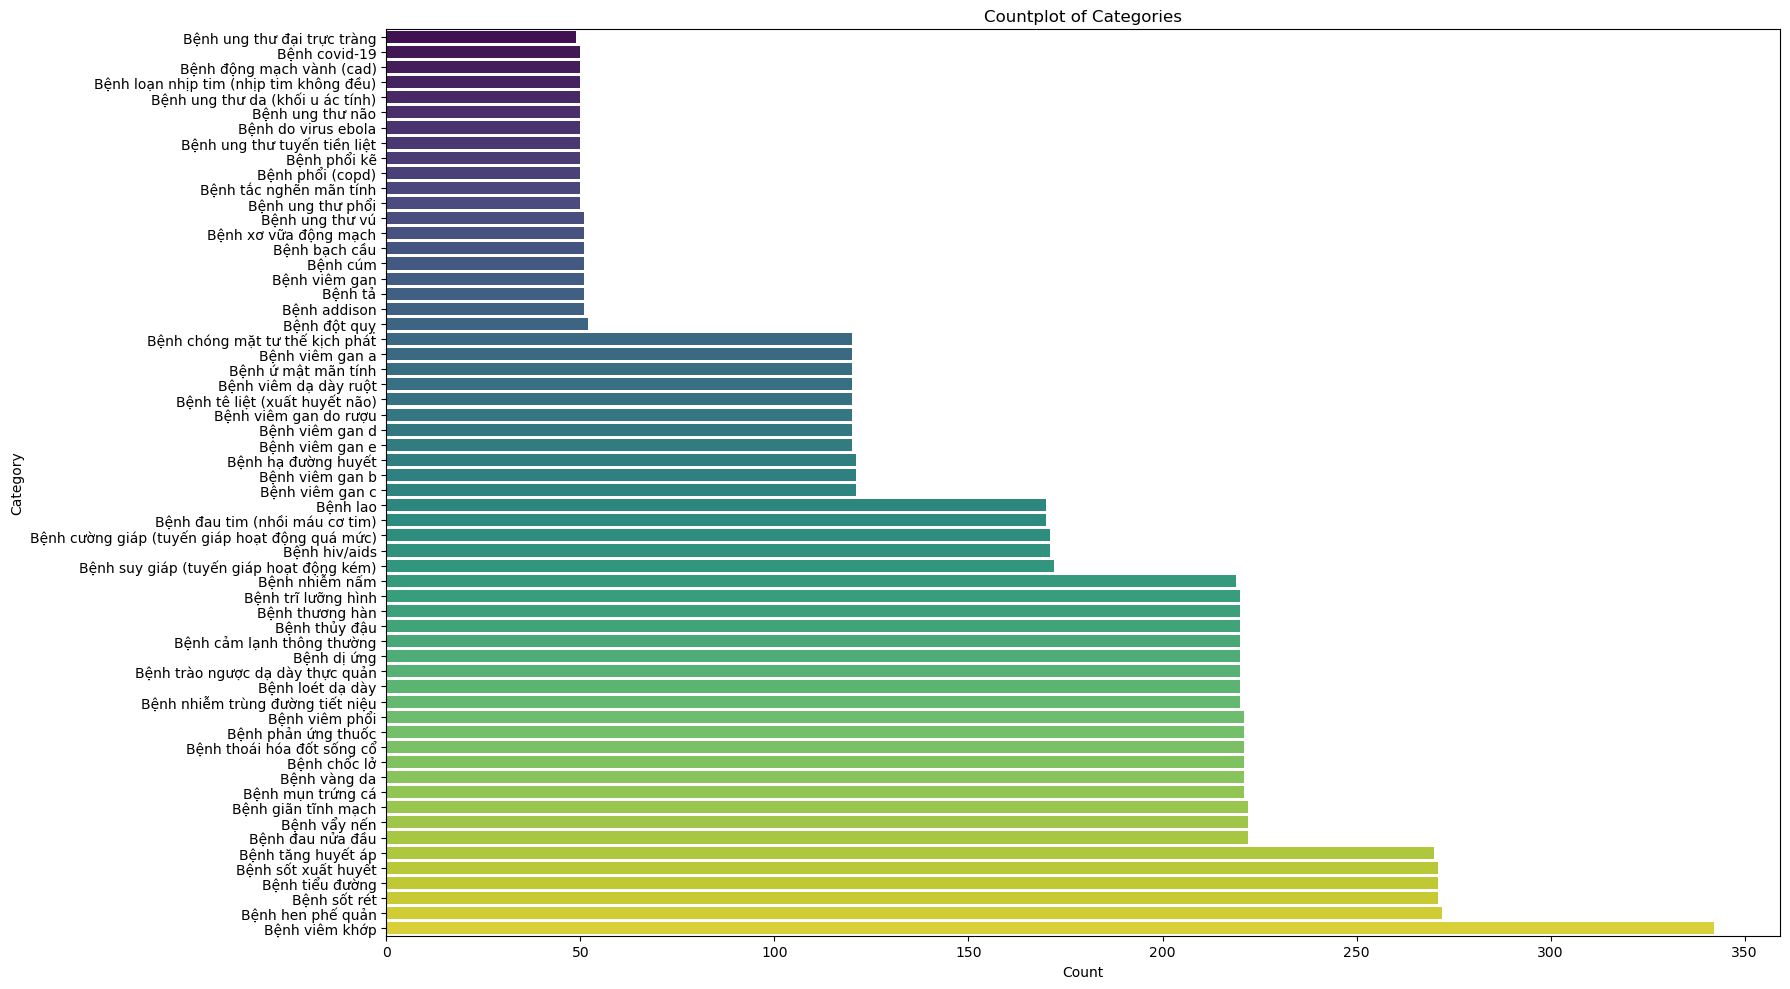

In [11]:
counts = data['label'].value_counts().sort_values()
sorted_categories = counts.index.tolist()


plt.figure(figsize=(18, 10))
sns.countplot(y='label', data=data, order=sorted_categories, palette='viridis')
plt.yticks(rotation=0)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Countplot of Categories')
plt.tight_layout()
plt.show()

### 5. Chia dữ liệu thành tập train:test


In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=100, shuffle=True)

### 6. Mã hóa TF-IDF cột text cho mô hình SVM

In [13]:
tfidf = TF_IDF(data['text'])
X_train_ml = [tfidf.encode_new_document(doc) for doc in X_train]
X_test_ml = [tfidf.encode_new_document(doc) for doc in X_test]

### 7. Mã hóa LabelEncoder cột label cho mô hình SVM

In [14]:
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train)
y_test_ml = label_encoder.transform(y_test)

### 8. Huấn luyện mô hình SVM

In [15]:
model_svm = SVC(C=1.5)
model_svm.fit(X_train_ml, y_train_ml)

SVC(C=1.5)

### 9. Đánh giá mô hình trên tập test

In [16]:
y_pred = model_svm.predict(X_test_ml)

In [17]:
accuracy = accuracy_score(y_test_ml, y_pred)
precision = precision_score(y_test_ml, y_pred, average='macro')
recall = recall_score(y_test_ml, y_pred, average='macro')
f1 = f1_score(y_test_ml, y_pred, average='macro')

In [18]:
accuracy, precision, recall, f1

(0.9570863918690006,
 0.9520993598345222,
 0.9037914429653331,
 0.9218889922509058)

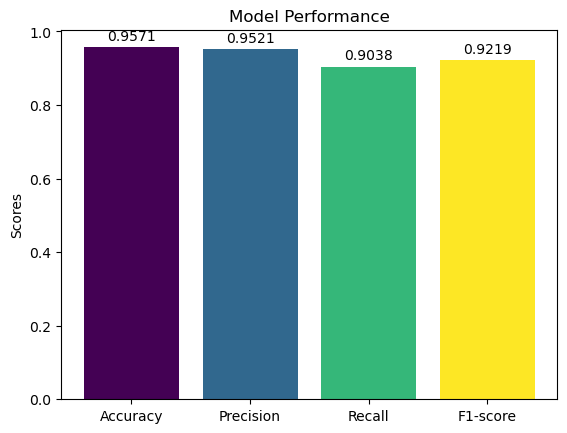

In [19]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

model_scores = [accuracy, precision, recall, f1]

colors = plt.cm.viridis(np.linspace(0, 1, len(metrics)))

x = range(len(metrics))

fig, ax = plt.subplots()
bars = ax.bar(x, model_scores, color=colors)

ax.set_ylabel('Scores')
ax.set_title('Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars)

plt.show()


### 10. Mã hóa bằng từ điển cột text cho LSTM

In [20]:
max_len = 100
encoder = TextEncoder(max_len=max_len)
encoder.process_corpus(data['text'])
X_train_lstm = encoder.transform(X_train)
X_test_lstm = encoder.transform(X_test)

### 11. Mã hóa OneHotEncoder cột label cho mô hình LSTM

In [21]:
ohe = OneHotEncoder()
ohe.fit_transform(data[['label']])
y_train_lstm = ohe.transform(pd.DataFrame(y_train))
y_test_lstm = ohe.transform(pd.DataFrame(y_test))

### 12. Huấn luyện mô hình LSTM

In [22]:
max_words = 3000
def define_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
    model.add((LSTM(128, return_sequences=False)))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
model = define_model()

c:\Users\84936\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
history = model.fit(X_train_lstm, y_train_lstm.toarray(), batch_size=36, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.1946 - loss: 3.4857 - val_accuracy: 0.7558 - val_loss: 1.1517
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8300 - loss: 0.8033 - val_accuracy: 0.8941 - val_loss: 0.4745
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9346 - loss: 0.3336 - val_accuracy: 0.9393 - val_loss: 0.2998
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9685 - loss: 0.1831 - val_accuracy: 0.9428 - val_loss: 0.2522
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9778 - loss: 0.1290 - val_accuracy: 0.9640 - val_loss: 0.1943
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9847 - loss: 0.0823 - val_accuracy: 0.9570 - val_loss: 0.1796
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9892 - loss: 0.0596 - val_accuracy: 0.9633 - val_loss: 0.1631
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9828 - loss: 0.1036 - 

In [25]:
y_pred_lstm= model.predict(X_test_lstm)
y_pred_lstm = y_pred_lstm.argmax(axis = 1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [26]:
y_pred_lstm

array([34, 13,  2, ..., 11, 19, 51], dtype=int64)

### 13. Đánh giá mô hình LSTM

In [27]:
accuracy = accuracy_score(y_test_ml,  y_pred_lstm)
precision = precision_score(y_test_ml, y_pred_lstm, average='macro')
recall = recall_score(y_test_ml, y_pred_lstm, average='macro')  
f1 = f1_score(y_test_ml, y_pred_lstm, average='macro')  

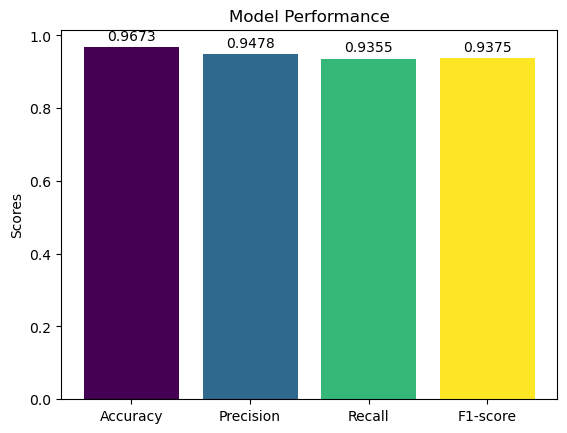

In [29]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

model_scores = [accuracy, precision, recall, f1]

colors = plt.cm.viridis(np.linspace(0, 1, len(metrics)))

x = range(len(metrics))

fig, ax = plt.subplots()
bars = ax.bar(x, model_scores, color=colors)

ax.set_ylabel('Scores')
ax.set_title('Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars)

plt.show()

### 14. Lưu lại mô hình tốt nhất và dự đoán cho 1 mẫu bất kỳ

In [30]:
import joblib
model.save("model\model.keras")
joblib.dump(label_encoder, 'model\label_encoder.joblib')
joblib.dump(encoder, 'model\encoder.joblib')

['model\\encoder.joblib']

In [34]:
model_lstm = keras.models.load_model(r"model\model.keras")
encoder = joblib.load(r'model\encoder.joblib')
label_encoder = joblib.load(r'model\label_encoder.joblib')
sample_text = "Tôi cảm thấy khó ngủ do ngứa ngáy và khó chịu do phát ban gây ra. Có những vết lõm nhỏ trên móng tay của tôi, điều này thực sự đáng lo ngại."
preprocessor = TextPreprocessor(r'dataset/vietnamese.txt')
sample_text = preprocessor.preprocess_text(sample_text)
lstm_vector = encoder.transform([sample_text])
if np.sum(lstm_vector) == 0:
    print('Có vẻ như bạn chưa nhập vào 1 triệu chứng?')
else:
    y_pred_lstm = model_lstm.predict(lstm_vector)
    predictions = y_pred_lstm.argmax(axis=1)
    predictions = label_encoder.inverse_transform([predictions])
    print(f"Nhãn dự đoán của mô hình là: {predictions[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Nhãn dự đoán của mô hình là: Bệnh vẩy nến


c:\Users\84936\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
